In [1]:


%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp
from numba import jit
figsize(20,6)
prefix="voice3_5b"
def filepre(nm):
    return "tmp/"+prefix+"_"+nm

Populating the interactive namespace from numpy and matplotlib


In [2]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


22050


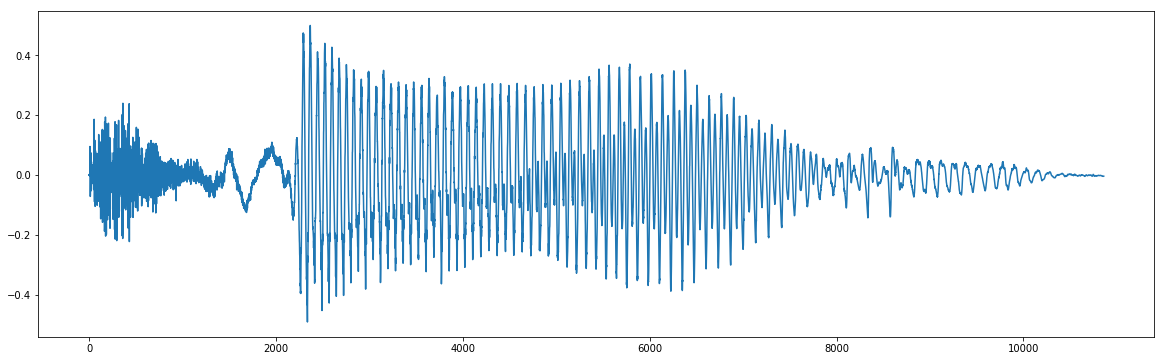

In [3]:
y, sr = librosa.load("audios/197016__margo-heston__two-f.wav")
y = y[4140:15000] 
y = y / np.max(y) * 0.5
plot(y)
print(sr)

In [4]:
Audio(data=y[:],rate=sr)

18
40
61
77
95
115
133
153
171
191
211
229
247
267
284
300
320
337
354
373
389
406
423
440
456
474
490
506
522
539
556
573
589
606
622
638
657
674
692
708
724
740
757
773
789
805
825
843
863
880
899
917
935
952
968
991
1008
1025
1046
1062
1078
1094
1113
1130
1149
1170
1191
1207
1363
1407
1426
1446
1547
1567
1802
2070
2118
2136
2238
2312
2385
2465
2541
2617
2693
2772
2850
2931
3007
3090
3167
3248
3329
3410
3491
3574
3655
3743
3822
3905
3990
4073
4158
4245
4333
4420
4509
4597
4688
4713
4780
4808
4874
4903
4969
5001
5067
5099
5165
5200
5268
5302
5371
5409
5475
5517
5582
5628
5692
5738
5802
5852
5918
5969
6034
6088
6154
6209
6276
6332
6398
6456
6524
6584
6654
6714
6783
6845
6914
6976
7046
7110
7183
7247
7321
7386
7460
7526
7602
7666
7743
7795
7885
7935
8031
8072
8150
8203
8298
8380
8426
8550
8625
8663
8788
8913
9039
9168
9294
9425
9554
9683
9807
9933
10058
10183
10300
10354
10433
10532
10556
10602
10640
10678
10708
10727
10753
10800
max length:  268
min length:  16


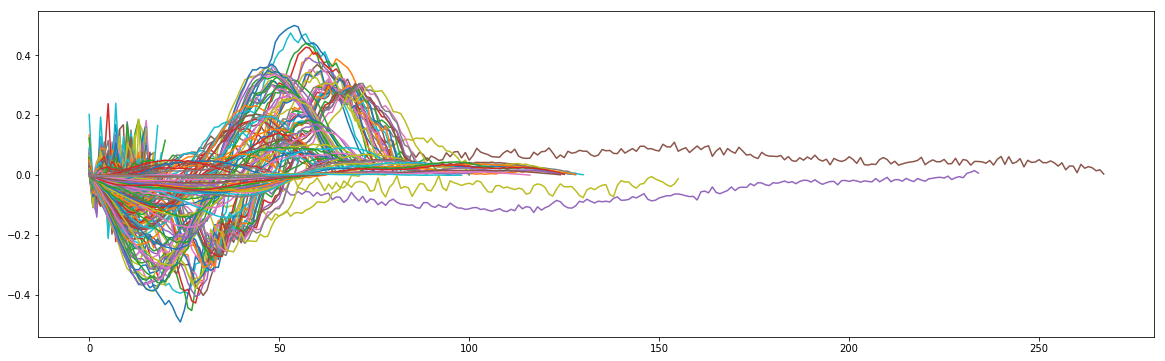

In [5]:
#divide out windows
patterns = []
    
minPatternSize = 15
lastCrossing=0
for i in range(y.shape[0]-1):
    if (i-lastCrossing) > minPatternSize and y[i] >=0 and y[i+1] < 0:
        print(i)
        segment = y[lastCrossing:i]
        patterns.append(segment)
        lastCrossing = i
#convert to numpy
patterns = np.array(patterns, dtype=np.object)
patternLengths = [x.shape[0] for x in patterns]
maxPatternLen = np.max(patternLengths)
minPatternLen = np.min(patternLengths)
print("max length: ", maxPatternLen)
print("min length: ", minPatternLen)
for p in patterns:
    plot(p)

In [6]:
def computeConceptor(p, net, i_pattern, alpha):
    print('Computing conceptor, alpha: ', alpha)
#     Cs = np.zeros((4, 1), dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = (S.dot(linalg.inv(S + pow(alpha, -2) * np.eye(p['N']))))

    C =  U.dot(Snew).dot(U.T);
#     Cs[0,0] = C
#     Cs[1,0] = U
#     Cs[2,0] = diag(Snew)
#     Cs[3,0] = diag(S)

    return C


def testConceptor(p, C, net, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
    LR = np.diag(p['LR'])
    LROneMinus = np.diag(1.0 - p['LR'])
    for i_trial in range(trials):
        x_CTestPL = np.zeros((p['N'], recallTestLength))
        z_CTestPL = np.zeros((p['N'], recallTestLength))
        x = 0.5 * np.random.randn(p['N'],1)
        z = x
        for n in range(recallTestLength + p['washoutLength']):
            xOld = x
            Wtarget = (net['W'].dot(x))
            leakTerm = LROneMinus.dot(xOld)
            newX =tanh(Wtarget + net['Wbias'])
            newXLeaked = LR.dot(newX)
            z = leakTerm + newXLeaked
            x = C.dot(z)
            xPrev = x
            if (n > p['washoutLength']):
                x_CTestPL[:,n-p['washoutLength']] = x.T
                z_CTestPL[:,n-p['washoutLength']] = z.T

        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)



In [7]:
#create a random reservoir and load it with patterns using Jaeger's method
def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLength']))
    pCollector = np.zeros((1, p['learnLength']))
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], 0));
    allTrainOuts = np.zeros((1, 0));
    patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
    print('Loading patterns: ', end='')
    LR = np.diag(p['LR'])
    LROneMinus = np.diag(1.0 - p['LR'])
#     print(LR)
#     print(LROneMinus)
    for i_pattern in range(p['patts'].shape[0]):
        print(i_pattern, " ", end='')
        patt = p['patts'][i_pattern]
        pattLearnLen = patt.size * p['learnLength']
        xCollector = np.zeros((p['N'] + 1, pattLearnLen));
        xOldCollector = np.zeros((p['N'], pattLearnLen));
        WTargetCollector = np.zeros((p['N'], pattLearnLen));
        pCollector = np.zeros((1, pattLearnLen));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + pattLearnLen):
            u = patt.take(n, mode='wrap')
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            leakTerm = LROneMinus.dot(xOld)
            newX =tanh(Wtarget + Wbias)
            newXLeaked = LR.dot(newX)
            x = leakTerm + newXLeaked

            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
                
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / pattLearnLen
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
    print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
    print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
    print("NRMSE W: ", NRMSE_W, " :: ", end='')
    print("absSize W: ", absSize_W)

    data ={k: v for k, v in locals().items() if k in 
           ('p','Win','Wstar', 'Wbias','NRMSE_W', 'absSize_W','patternRs','W',
            'Wout','NRMSE_readout', 'absSize_readout')}
    return data
    





N=1400
startPattern=100
endPattern=170
LRs = np.ones(N) * 0.92
params = {'N':N, 'NetSR':1.5, 'NetinpScaling':1,'BiasScaling':0.5,'TychonovAlpha':0.0001,
         'washoutLength':maxPatternLen * 2, 'learnLength':2, 'TychonovAlphaReadout':0.0001,
          'LR': LRs,
          'patts':patterns[startPattern:endPattern]
         }


# net =makeLoadedNetwork_v2(params)
# plot(net['allTrainxArgs'].T[:])
# None

# sampleSize = 10
# loadedNets = np.zeros(sampleSize, dtype=np.object)
# for i_net, net in enumerate(loadedNets):
#     print(i_net)
#     loadedNets[i_net] = makeLoadedNetwork_v2(params)
# # nrmses = [x['NRMSE_W'] * x['NRMSE_readout'] for x in loadedNets]
# nrmses = [x['NRMSE_W'] for x in loadedNets]
# bestNetwork = np.argmin(nrmses)
# print("NRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_W'], ", loadedNets[bestNetwork]['NRMSE_readout']", "avg: ", np.mean(nrmses) )

bestNet = 0
def findAModel():
    sampleSize = 10
    bestScore = 9999999999
#     loadedNets = np.zeros(sampleSize, dtype=np.object)
    for i_net in range(sampleSize):
        print(i_net)
        newNetwork  = makeLoadedNetwork_v2(params)
        if (newNetwork['NRMSE_W'] < bestScore):
            print("New best score")
            bestScore = newNetwork['NRMSE_W']
            bestNet = newNetwork
#     for i_net, net in enumerate(loadedNets):
#         print(i_net)
#         loadedNets[i_net] = makeLoadedNetwork_v2(params)
    # nrmses = [x['NRMSE_W'] * x['NRMSE_readout'] for x in loadedNets]
#     nrmses = [x['NRMSE_W'] for x in loadedNets]
#     bestNetwork = np.argmin(nrmses)
    print("NRMSEs: best: ", bestNet['NRMSE_W'], ",", bestNet['NRMSE_readout'])
    return bestNet

bestNet = findAModel()

# import scipy
# def fitnessf(aperture, *args):
#     print('Pattern: ', args[0])
#     cnet = computeConceptor(params, loadedNets[bestNetwork], args[0], aperture)
#     atten = testConceptor(params, cnet, maxPatternLen * 2)
#     return atten

# #scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=0.1, args = (0,))
# apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=1, args = (x,)) 
#              for x in np.arange(params['patts'].shape[0])]

# #store conceptors with calculated apertures
# patternCs = np.zeros(len(apertures), dtype=np.object)
# for i_patt in range(patternCs.size):
#     patternCs[i_patt] = computeConceptor(params, loadedNets[bestNetwork], i_patt, apertures[i_patt])


0
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  
NRMSE readout:  0.008552808665176295  :: absSize readout:  0.0026399965624773996
NRMSE W:  0.006009264181980186  :: absSize W:  0.006059424854678774
New best score
1
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  
NRMSE readout:  0.0008241252599652802  :: absSize readout:  0.0026600451977584223
NRMSE W:  0.0031944681776615476  :: absSize W:  0.024454688227227378
New best score
2
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19

In [8]:
import scipy
def fitnessf(aperture, *args):
    print('Pattern: ', args[0])
    C = computeConceptor(params, bestNet, args[0], aperture)
    atten = testConceptor(params, C, bestNet, params['patts'][args[0]].size * params['learnLength'])
    return atten

#scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=0.1, args = (0,))
apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=1, args = (x,)) 
             for x in np.arange(params['patts'].shape[0])]

#store conceptors with calculated apertures
patternCs = np.zeros(len(apertures), dtype=np.object)
for i_patt in range(patternCs.size):
    patternCs[i_patt] = computeConceptor(params, bestNet, i_patt, apertures[i_patt])


Pattern:  0
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  3.06373e-06        initial
Pattern:  0
Computing conceptor, alpha:  618.0339887498948
    2        618.034  3.17273e-06        golden
Pattern:  0
Computing conceptor, alpha:  236.0679774997897
    3        236.068  2.85908e-06        golden
Pattern:  0
Computing conceptor, alpha:  145.89803375031545
    4        145.898  2.69246e-06        golden
Pattern:  0
Computing conceptor, alpha:  90.16994374947424
    5        90.1699   3.0423e-06        golden
Pattern:  0
Computing conceptor, alpha:  174.3934939635051
    6        174.393   2.7291e-06        parabolic
Pattern:  0
Computing conceptor, alpha:  124.61179749810726
    7        124.612  2.71443e-06        golden
Pattern:  0
Computing conceptor, alpha:  146.3379753599284
    8        146.338  2.69032e-06        parabolic
Pattern:  0
Computing conceptor, alpha:  157.0542298944897
    9        157.054  2

    2        618.034  2.56549e-06        golden
Pattern:  5
Computing conceptor, alpha:  236.0679774997897
    3        236.068  2.43808e-06        golden
Pattern:  5
Computing conceptor, alpha:  145.89803375031545
    4        145.898  2.54924e-06        golden
Pattern:  5
Computing conceptor, alpha:  284.99377355552417
    5        284.994  2.45536e-06        parabolic
Pattern:  5
Computing conceptor, alpha:  201.62612375115668
    6        201.626  2.45955e-06        golden
Pattern:  5
Computing conceptor, alpha:  245.4567595421344
    7        245.457  2.44239e-06        parabolic
Pattern:  5
Computing conceptor, alpha:  222.91236000336485
    8        222.912  2.44816e-06        golden
Pattern:  5
Computing conceptor, alpha:  236.53539316928916
    9        236.535  2.43843e-06        parabolic
Pattern:  5
Computing conceptor, alpha:  231.0429787591482
   10        231.043  2.44601e-06        golden
Pattern:  5
Computing conceptor, alpha:  234.14859877429006
   11        234.149  

    2        618.034  4.62064e-06        golden
Pattern:  10
Computing conceptor, alpha:  763.9320225002102
    3        763.932  4.72367e-06        golden
Pattern:  10
Computing conceptor, alpha:  510.9821859814314
    4        510.982  4.69705e-06        parabolic
Pattern:  10
Computing conceptor, alpha:  673.762078750736
    5        673.762  4.74405e-06        golden
Pattern:  10
Computing conceptor, alpha:  577.1438386492919
    6        577.144  4.63572e-06        golden
Pattern:  10
Computing conceptor, alpha:  639.3202250021029
    7         639.32  4.63833e-06        golden
Pattern:  10
Computing conceptor, alpha:  602.4153412165495
    8        602.415    4.727e-06        golden
Pattern:  10
Computing conceptor, alpha:  626.1646075056781
    9        626.165  4.62288e-06        golden
Pattern:  10
Computing conceptor, alpha:  612.0681962504616
   10        612.068  4.67739e-06        golden
Pattern:  10
Computing conceptor, alpha:  621.1396087650367
   11         621.14  4.69

   14        85.1953  3.47907e-06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  15
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  5.27405e-06        initial
Pattern:  15
Computing conceptor, alpha:  618.0339887498948
    2        618.034  5.12961e-06        golden
Pattern:  15
Computing conceptor, alpha:  763.9320225002102
    3        763.932  4.95039e-06        golden
Pattern:  15
Computing conceptor, alpha:  854.1019662496844
    4        854.102  4.89162e-06        golden
Pattern:  15
Computing conceptor, alpha:  942.4407940567058
    5        942.441  4.78267e-06        parabolic
Pattern:  15
Computing conceptor, alpha:  908.698364360748
    6        908.698  4.81397e-06        golden
Pattern:  15
Computing conceptor, alpha:  964.4264543615892
    7        964.426  4.76714e-06        golden
Pattern:  15
Computing conce

    2        618.034  3.49285e-06        golden
Pattern:  20
Computing conceptor, alpha:  236.0679774997897
    3        236.068  3.25308e-06        golden
Pattern:  20
Computing conceptor, alpha:  201.5084428549333
    4        201.508  3.19176e-06        parabolic
Pattern:  20
Computing conceptor, alpha:  124.53906670441468
    5        124.539  3.17975e-06        golden
Pattern:  20
Computing conceptor, alpha:  157.64554940114195
    6        157.646  3.17484e-06        parabolic
Pattern:  20
Computing conceptor, alpha:  151.7753019751148
    7        151.775  3.17283e-06        parabolic
Pattern:  20
Computing conceptor, alpha:  145.20670325312994
    8        145.207   3.1694e-06        parabolic
Pattern:  20
Computing conceptor, alpha:  137.3123685586503
    9        137.312  3.17067e-06        golden
Pattern:  20
Computing conceptor, alpha:  142.96810795337177
   10        142.968  3.16858e-06        parabolic
Pattern:  20
Computing conceptor, alpha:  142.12837455311382
   11   

   12        124.516  4.35669e-06        golden
Pattern:  24
Computing conceptor, alpha:  122.26922814862515
   13        122.269  4.35682e-06        golden
Pattern:  24
Computing conceptor, alpha:  123.56327822715019
   14        123.563  4.31395e-06        golden
Pattern:  24
Computing conceptor, alpha:  123.92710407018122
   15        123.927  4.35692e-06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  25
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  1.34187e-06        initial
Pattern:  25
Computing conceptor, alpha:  618.0339887498948
    2        618.034  1.36094e-06        golden
Pattern:  25
Computing conceptor, alpha:  236.0679774997897
    3        236.068   1.2672e-06        golden
Pattern:  25
Computing conceptor, alpha:  145.89803375031545
    4        145.898  1.14446e-06        golden
Pattern:  25
Computing con

    8        109.272  2.13594e-06        parabolic
Pattern:  29
Computing conceptor, alpha:  124.61179749810726
    9        124.612  2.11406e-06        golden
Pattern:  29
Computing conceptor, alpha:  118.27123289252188
   10        118.271  2.10638e-06        parabolic
Pattern:  29
Computing conceptor, alpha:  118.62599542794099
   11        118.626  2.10849e-06        parabolic
Pattern:  29
Computing conceptor, alpha:  115.66811432334944
   12        115.668  2.10366e-06        golden
Pattern:  29
Computing conceptor, alpha:  116.65517563859976
   13        116.655  2.15448e-06        parabolic
Pattern:  29
Computing conceptor, alpha:  114.05929857085488
   14        114.059   2.1818e-06        golden
Pattern:  29
Computing conceptor, alpha:  115.05360138753275
   15        115.054  2.18293e-06        golden
Pattern:  29
Computing conceptor, alpha:  116.0451381967949
   16        116.045  2.13892e-06        golden

Optimization terminated successfully;
The returned value satisfies t

    7         216.55  4.39517e-06        golden
Pattern:  34
Computing conceptor, alpha:  223.53937796543227
    8        223.539  4.40675e-06        parabolic
Pattern:  34
Computing conceptor, alpha:  207.860961780456
    9        207.861  4.41672e-06        golden
Pattern:  34
Computing conceptor, alpha:  213.23117636526962
   10        213.231  4.39837e-06        golden
Pattern:  34
Computing conceptor, alpha:  219.2197984581641
   11         219.22  4.39906e-06        golden
Pattern:  34
Computing conceptor, alpha:  215.282415809788
   12        215.282  4.41883e-06        golden
Pattern:  34
Computing conceptor, alpha:  217.56986590349516
   13         217.57  4.41909e-06        golden
Pattern:  34
Computing conceptor, alpha:  216.06591955852957
   14        216.066  4.40772e-06        golden
Pattern:  34
Computing conceptor, alpha:  216.93964774675658
   15         216.94  4.42037e-06        golden

Optimization terminated successfully;
The returned value satisfies the terminatio

    7        145.454  2.41893e-06        parabolic
Pattern:  39
Computing conceptor, alpha:  124.33722367436121
    8        124.337  2.42068e-06        golden
Pattern:  39
Computing conceptor, alpha:  134.93294303734874
    9        134.933  2.42185e-06        parabolic
Pattern:  39
Computing conceptor, alpha:  141.43516796394192
   10        141.435  2.45237e-06        golden
Pattern:  39
Computing conceptor, alpha:  143.91879688340373
   11        143.919  2.42486e-06        golden
Pattern:  39
Computing conceptor, alpha:  144.86745871519597
   12        144.867  2.44823e-06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  40
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  1.89714e-06        initial
Pattern:  40
Computing conceptor, alpha:  618.0339887498948
    2        618.034  1.88608e-06        golden
Pattern:  40
Comput

   10        236.401  2.06133e-06        parabolic
Pattern:  44
Computing conceptor, alpha:  235.4601896320123
   11         235.46  2.06721e-06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  45
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   4.4845e-06        initial
Pattern:  45
Computing conceptor, alpha:  618.0339887498948
    2        618.034  4.93638e-06        golden
Pattern:  45
Computing conceptor, alpha:  236.0679774997897
    3        236.068  4.02615e-06        golden
Pattern:  45
Computing conceptor, alpha:  145.89803375031545
    4        145.898  3.71491e-06        golden
Pattern:  45
Computing conceptor, alpha:  90.16994374947424
    5        90.1699  3.74921e-06        golden
Pattern:  45
Computing conceptor, alpha:  129.0727410503148
    6        129.073  3.62801e-06        parabolic
Pattern:  45
Computing 

   13        177.731  2.30087e-06        parabolic
Pattern:  49
Computing conceptor, alpha:  176.1858483260507
   14        176.186  2.27952e-06        golden
Pattern:  49
Computing conceptor, alpha:  176.83556146176826
   15        176.836  2.29651e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  50
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   1.5077e-06        initial
Pattern:  50
Computing conceptor, alpha:  618.0339887498948
    2        618.034  1.64981e-06        golden
Pattern:  50
Computing conceptor, alpha:  236.0679774997897
    3        236.068  1.38492e-06        golden
Pattern:  50
Computing conceptor, alpha:  145.89803375031545
    4        145.898  1.40267e-06        golden
Pattern:  50
Computing conceptor, alpha:  213.35776843922426
    5        213.358  1.36711e-06        parabolic
Pattern:  50
Compu

 
 Func-count     x          f(x)          Procedure
    1        381.966  1.58032e-06        initial
Pattern:  55
Computing conceptor, alpha:  618.0339887498948
    2        618.034  1.85228e-06        golden
Pattern:  55
Computing conceptor, alpha:  236.0679774997897
    3        236.068  1.29464e-06        golden
Pattern:  55
Computing conceptor, alpha:  145.89803375031545
    4        145.898  1.20708e-06        golden
Pattern:  55
Computing conceptor, alpha:  74.87424011528185
    5        74.8742  1.72743e-06        parabolic
Pattern:  55
Computing conceptor, alpha:  180.33988749894849
    6         180.34  1.21602e-06        golden
Pattern:  55
Computing conceptor, alpha:  152.95730899655547
    7        152.957  1.20856e-06        parabolic
Pattern:  55
Computing conceptor, alpha:  118.76935859169106
    8        118.769  1.27606e-06        golden
Pattern:  55
Computing conceptor, alpha:  135.53580190947588
    9        135.536   1.2242e-06        golden
Pattern:  55
Computing 

    2        618.034  4.40704e-06        golden
Pattern:  60
Computing conceptor, alpha:  236.0679774997897
    3        236.068  3.31211e-06        golden
Pattern:  60
Computing conceptor, alpha:  145.89803375031545
    4        145.898  2.96497e-06        golden
Pattern:  60
Computing conceptor, alpha:  90.16994374947424
    5        90.1699  2.96601e-06        golden
Pattern:  60
Computing conceptor, alpha:  118.38417227400873
    6        118.384   2.8972e-06        parabolic
Pattern:  60
Computing conceptor, alpha:  118.05083718475436
    7        118.051  2.89593e-06        parabolic
Pattern:  60
Computing conceptor, alpha:  107.40128352919118
    8        107.401  2.91256e-06        golden
Pattern:  60
Computing conceptor, alpha:  114.3250736956652
    9        114.325  2.90892e-06        parabolic
Pattern:  60
Computing conceptor, alpha:  117.15893887860541
   10        117.159  2.89594e-06        parabolic
Pattern:  60
Computing conceptor, alpha:  117.71750210044415
   11     

 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00620777        initial
Pattern:  65
Computing conceptor, alpha:  618.0339887498948
    2        618.034     0.216091        golden
Pattern:  65
Computing conceptor, alpha:  236.0679774997897
    3        236.068   3.9055e-06        golden
Pattern:  65
Computing conceptor, alpha:  299.42407523801955
    4        299.424  9.08718e-06        parabolic
Pattern:  65
Computing conceptor, alpha:  267.6664928422248
    5        267.666  4.93983e-06        parabolic
Pattern:  65
Computing conceptor, alpha:  241.27123358001387
    6        241.271  4.19365e-06        parabolic
Pattern:  65
Computing conceptor, alpha:  145.89803375031545
    7        145.898  7.94481e-06        golden
Pattern:  65
Computing conceptor, alpha:  201.62612375115668
    8        201.626  4.11013e-06        golden
Pattern:  65
Computing conceptor, alpha:  220.76768489587354
    9        220.768  3.76034e-06        parabolic
Pattern:  65
Comp

    9        89.4643  6.03323e-06        parabolic
Pattern:  69
Computing conceptor, alpha:  94.71396355761951
   10         94.714  6.04942e-06        golden
Pattern:  69
Computing conceptor, alpha:  91.88732015167075
   11        91.8873   6.0418e-06        parabolic
Pattern:  69
Computing conceptor, alpha:  90.58944809817181
   12        90.5894  6.04968e-06        parabolic
Pattern:  69
Computing conceptor, alpha:  89.83660907870451
   13        89.8366   6.0424e-06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Computing conceptor, alpha:  146.67131086380468
Computing conceptor, alpha:  150.36542432919302
Computing conceptor, alpha:  236.0679774997897
Computing conceptor, alpha:  472.1359549995793
Computing conceptor, alpha:  130.5363443604649
Computing conceptor, alpha:  235.3348400639323
Computing conceptor, alpha:  173.7261617557939
Computing conceptor, alpha:  111.44278727963665
Computing conceptor,

0.03580847469400226
0.0643481483525489
0.09363834674538953
0.06537826451573259
0.0905770493717198
0.045829866391248086
0.0938754616056567
0.06239992344573659
0.08669190346226856
0.18669881430599677
0.05082228691663724
0.1776119320913044
0.0430408077842418
0.10900661893339124
0.049988563336127695
0.16212162443250439
0.03600988238130565
0.07978677966444314
0.0536262726553628
0.06911978933719082
0.03339553100091828
0.06416122381704588
0.025230118005582457
0.10777262162729194
0.04266246038861414
0.08493348673518807
0.03036394575710234
0.02910404534915851
0.0690105066399116
0.057772260827409966
0.039881757290439655
0.07348659901132588
0.12307885353541687
0.12611147908611134
0.04806694817641132
0.04575446951034746
0.11661128178098629
0.036325512676411355
0.15149582708176024
0.09543373594068749
0.03191923187481749
0.07607507376489052
0.03478501709120074
0.02624695075953468
0.04567221197669788
0.027139251149395954
0.0341652667659227
0.02709046228816588
0.03775086581787764
0.030421636540424332


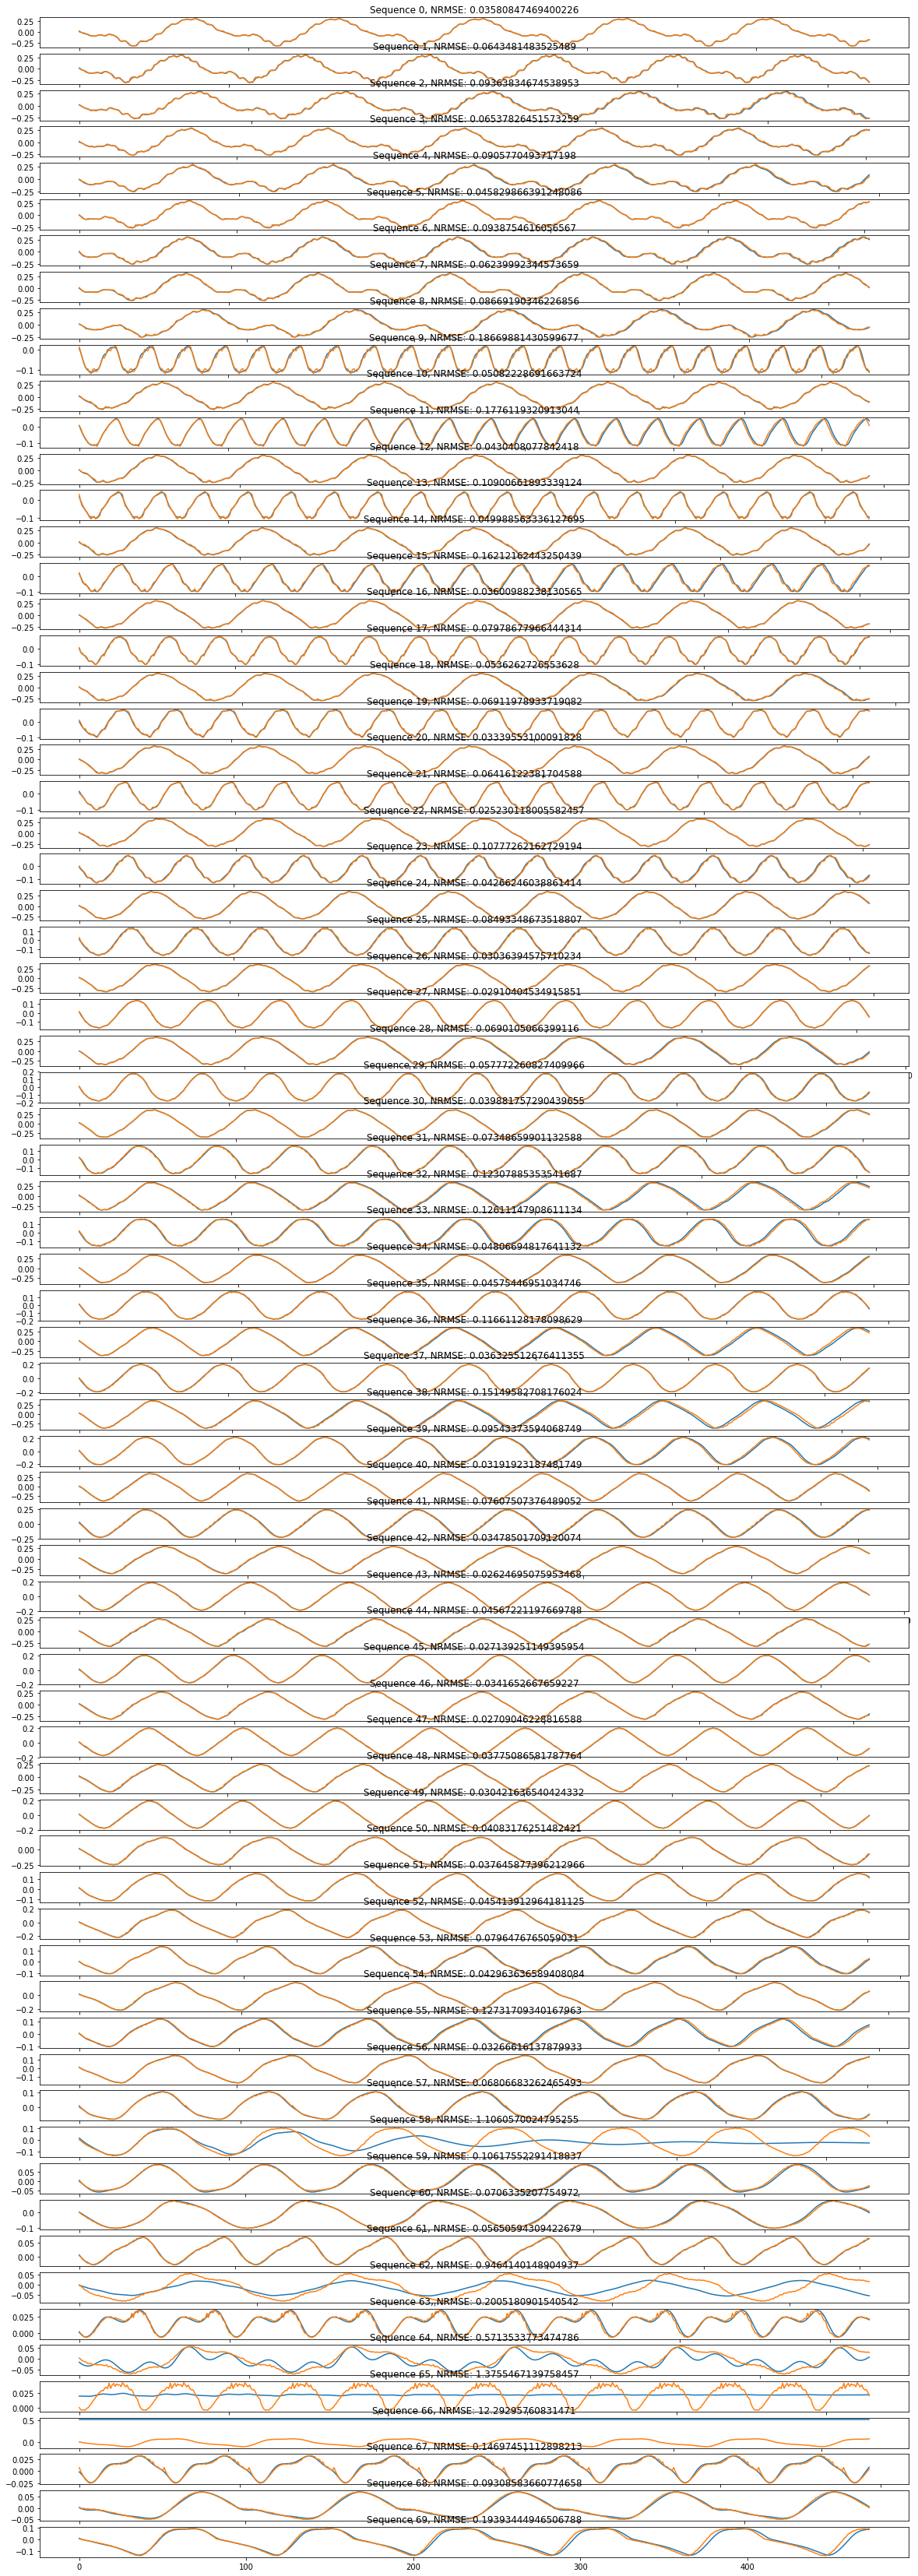

In [9]:
def plotConceptorPattern(p, C, net, recallTestLength, i_pattern):
    x_CTestPL = np.zeros((p['N'], recallTestLength, p['patts'].shape[0]))
    z_CTestPL = np.zeros((p['N'], recallTestLength, p['patts'].shape[0]))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].shape[0]))
#     C = cNet['Cs'][0,0]
    x = 0.5 * np.random.randn(p['N'],1)
    z = x
    LR = np.diag(p['LR'])
    LROneMinus = np.diag(1.0 - p['LR'])
    for n in range(recallTestLength + p['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + net['Wbias'])))
        x = C.dot(z)
        xPrev = x
        if (n > p['washoutLength']):
            x_CTestPL[:,n-p['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-p['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-p['washoutLength'],i_pattern] = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
    outputPattern = p_CTestPL[:,:,i_pattern][0]
    targetPattern = np.array([p['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    templateScan = np.correlate(outputPattern[:p['patts'][i_pattern].size*2],p['patts'][i_pattern])
    matchPoint = np.argmax(templateScan)
    if (matchPoint > 0):
        outputPattern = outputPattern[matchPoint:]
        targetPattern = targetPattern[:-matchPoint]
    score = nrmse(outputPattern, targetPattern) 
    print(score)
    plot(outputPattern)
    plot(targetPattern)
    return score
    
figsize(20,60)
scores = np.zeros(len(apertures))
for i_patt in range(len(apertures)):
    ax = subplot(len(apertures), 1, i_patt+1)
    scores[i_patt] = plotConceptorPattern(params, patternCs[i_patt], bestNet, maxPatternLen * 2, i_patt)
    ax.set_title("Sequence " + str(i_patt) + ", NRMSE: " + str(scores[i_patt]))    

plt.savefig(filepre("tests.pdf"))

0.30090012838876196
[ 0.03580847  0.06434815  0.09363835  0.06537826  0.09057705  0.04582987
  0.09387546  0.06239992  0.0866919   0.18669881  0.05082229  0.17761193
  0.04304081  0.10900662  0.04998856  0.16212162  0.03600988  0.07978678
  0.05362627  0.06911979  0.03339553  0.06416122  0.02523012  0.10777262
  0.04266246  0.08493349  0.03036395  0.02910405  0.06901051  0.05777226
  0.03988176  0.0734866   0.12307885  0.12611148  0.04806695  0.04575447
  0.11661128  0.03632551  0.15149583  0.09543374  0.03191923  0.07607507
  0.03478502  0.02624695  0.04567221  0.02713925  0.03416527  0.02709046
  0.03775087  0.03042164  0.04083176  0.03764588  0.04541391  0.07964768
  0.04296364  0.12731709  0.03266616  0.06806683  1.106057    0.10617552
  0.07063352  0.05650594  0.94641401  0.20051809  0.57135338  1.37554671
 12.29295761  0.14697451  0.09308584  0.19393445]
[ 0.02523012  0.02624695  0.02709046  0.02713925  0.02910405  0.03036395
  0.03042164  0.03191923  0.03266616  0.03339553  0.03

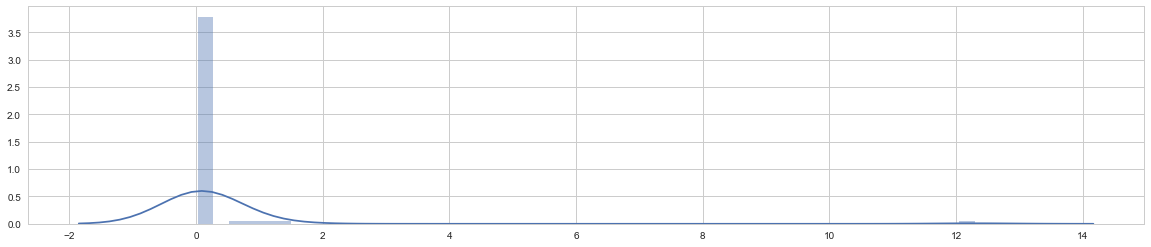

In [10]:
import seaborn as sns
sns.set(style="whitegrid")
print(np.mean(scores))
print(scores)
figsize(20,4)
# plot(sort(scores))
print(sort(scores))
# print(median(scores))
sns.distplot(scores)
plt.savefig(filepre("scoresDistrib.pdf"))

In [14]:

def render(p, lrMod=1.0, speed=1.0, xFade=0.05):
    audio = np.zeros(0)
    x = 0.5 * np.random.randn(p['N'],1)
    C = patternCs[0]
    
    LR = np.diag(p['LR'])
    LR = LR * lrMod
    LROneMinus = np.diag(1.0 - p['LR'])
    
    #run to washout
    for n in range(p['washoutLength']):
        xOld = x
        Wtarget = (bestNet['W'].dot(x))
        z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + bestNet['Wbias'])))
        x = C.dot(z)


    for i_patt in arange(startPattern,endPattern):
        xFadeTime=int(patterns[i_patt].shape[0] * xFade)
        for n in range(int(patterns[i_patt].shape[0] * speed)):
            C = patternCs[i_patt-startPattern]
            v=int(patterns[i_patt].shape[0] * speed)
            stepL = min(v - n - 1, xFadeTime)
            stepU = min(n, xFadeTime)
            m1 = 1.0
            if(n > v-xFadeTime-1 and i_patt < endPattern-1):
                m1 = (stepL + stepU) / (2*xFadeTime)
                nextC = patternCs[i_patt+1-startPattern]
                C = (m1 * C) + ((1.0-m1) * nextC)
            else:
                if (n < xFadeTime and i_patt > startPattern):
                    m1 = 0.5 - (n / (2*xFadeTime))
                    prevC = patternCs[i_patt-1-startPattern]
                    C = (m1 * prevC) + ((1.0-m1) * C)
#                 else:
#                     C = cNet['Cs'][0,0]
            
            xOld = x
            Wtarget = (bestNet['W'].dot(x))
            z = (LROneMinus.dot(xOld)) + (LR.dot(tanh(Wtarget + bestNet['Wbias'])))
            x = C.dot(z)

            newSample = bestNet['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
            audio = np.concatenate((audio, newSample))
    return audio


print("done")

done


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


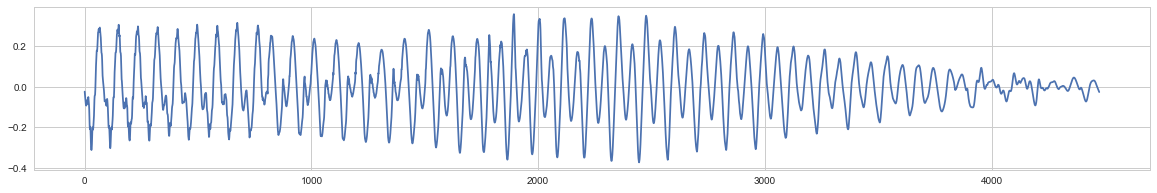

In [15]:
figsize(20,3)
audio = render(params, 1.0,1.0, 0.05)
plot(audio)
plt.savefig(filepre('TwoRecon.pdf'))
librosa.output.write_wav(filepre("twoRecon.wav"), librosa.resample(audio, sr, 44100), 44100)
Audio(data=audio,rate=sr)


In [12]:
np.sum(patternLengths[:100])

3905

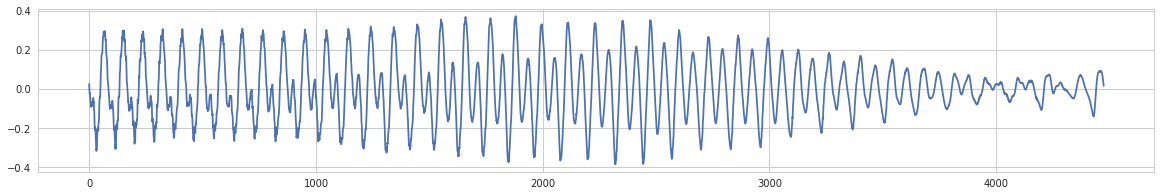

In [13]:
plot(y[3905:3905+audio.size])
Audio(data=y[3905:3905+audio.size],rate=sr)


1.3848871863760577


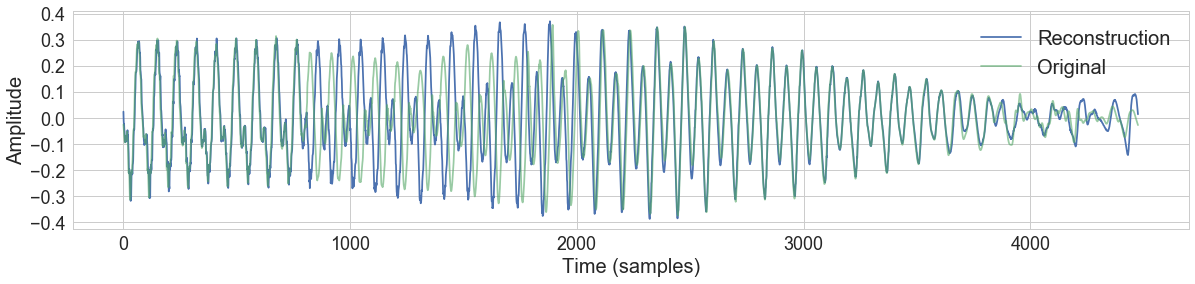

In [17]:
figsize(20,4)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plot(y[3905:3905+audio.size], alpha=1.0, label='Reconstruction')
plot(audio, alpha=0.6, label='Original')
plt.legend(fontsize=20)
plt.savefig(filepre("twoReconCompare.pdf"), bbox_inches='tight')
print(nrmse(audio, y[:audio.size]))

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


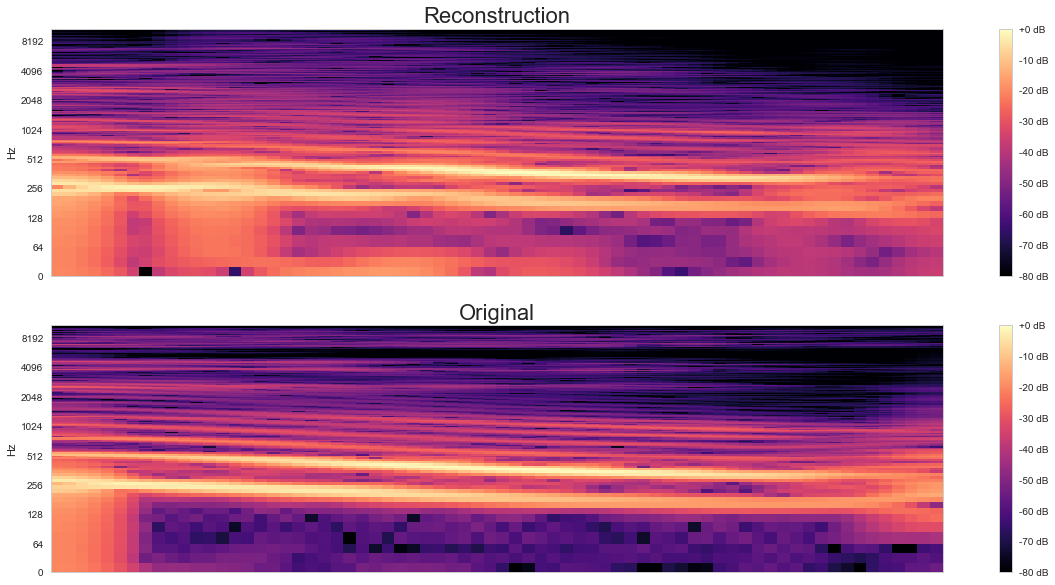

In [19]:
figsize(20,10)
import librosa.display
subplot(2,1,1)
CQT = librosa.amplitude_to_db(librosa.stft(audio, n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Reconstruction', fontsize=22)
subplot(2,1,2)
CQT = librosa.amplitude_to_db(librosa.stft(y[3905:3905+audio.size], n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Original', fontsize=22)
plt.savefig(filepre("exptSpectra.pdf"), bbox_inches='tight')